# Text Classification with SpaCy

A common task in NLP is **text classification**. This is "classification" in the conventional machine learning sense, and it is applied to text. Examples include spam detection, sentiment analysis, and tagging customer queries. 

In this tutorial, you'll learn text classification with spaCy. The classifier will detect spam messages, a common functionality in most email clients. Here is an overview of the data you'll use:

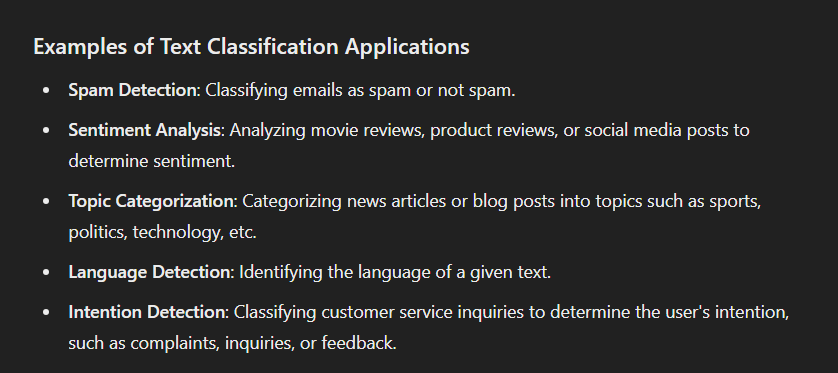


In [29]:
import pandas as pd

# Loading the spam data
# ham is the label for non-spam messages!!
spam = pd.read_csv('../input/nlp-course/spam.csv')
spam.head(10)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


# Bag of Words
Machine learning models don't learn from raw text data. Instead, you need to convert the text to something numeric.

The simplest common representation is a variation of one-hot encoding. You represent each document as a vector of term frequencies for each term in the vocabulary. The vocabulary is built from all the tokens (terms) in the corpus (the collection of documents). 

As an example, take the sentences "Tea is life. Tea is love." and "Tea is healthy, calming, and delicious." as our corpus. The vocabulary then is `{"tea", "is", "life", "love", "healthy", "calming", "and", "delicious"}` (ignoring punctuation).

For each document, count up how many times a term occurs, and place that count in the appropriate element of a vector. The first sentence has "tea" twice and that is the first position in our vocabulary, so we put the number 2 in the first element of the vector. Our sentences as vectors then look like 

$$
\begin{align}
v_1 &= \left[\begin{matrix} 2 & 2 & 1 & 1 & 0 & 0 & 0 & 0 \end{matrix}\right] \\
v_2 &= \left[\begin{matrix} 1 & 1 & 0 & 0 & 1 & 1 & 1 & 1 \end{matrix}\right]
\end{align}
$$

This is called the **bag of words** representation. You can see that documents with similar terms will have similar vectors. Vocabularies frequently have tens of thousands of terms, so these vectors can be very large.

Another common representation is **TF-IDF (Term Frequency - Inverse Document Frequency)**. TF-IDF is similar to bag of words except that each term count is scaled by the term's frequency in the corpus. Using TF-IDF can potentially improve your models. You won't need it here. Feel free to look it up though!


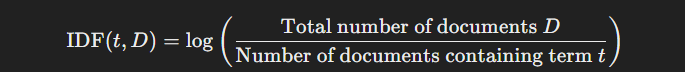


# Building a Bag of Words model

Once you have your documents in a bag of words representation, you can use those vectors as input to any machine learning model. spaCy handles the bag of words conversion and building a simple linear model for you with the `TextCategorizer` class.

The TextCategorizer is a spaCy **pipe**. Pipes are classes for processing and transforming tokens. When you create a spaCy model with `nlp = spacy.load('en_core_web_sm')`, there are default pipes that perform part of speech tagging, entity recognition, and other transformations. When you run text through a model `doc = nlp("Some text here")`, the output of the pipes are attached to the tokens in the `doc` object. The lemmas for `token.lemma_` come from one of these pipes.

You can remove or add pipes to models. What we'll do here is create an empty model without any pipes (other than a tokenizer, since all models always have a tokenizer). Then, we'll create a TextCategorizer pipe and add it to the empty model.

In [30]:
import spacy

# Create an empty model
nlp = spacy.blank("en")  #Does not contain any pre-trained components.

# Add the TextCategorizer to the empty model
textcat = nlp.add_pipe("textcat")  
#"textcat' Adds a text classification component to the pipeline, which can be trained on custom data. built-in thing.

Next we'll add the labels to the model. Here "ham" are for the real messages, "spam" are spam messages.

In [31]:
# Add labels to text classifier
textcat.add_label("ham")
textcat.add_label("spam")
print("labels added")

labels added


# Training a Text Categorizer Model

Next, you'll convert the labels in the data to the form TextCategorizer requires. For each document, you'll create a dictionary of boolean values for each class. 

For example, if a text is "ham", we need a dictionary `{'ham': True, 'spam': False}`. The model is looking for these labels inside another dictionary with the key `'cats'`.

In [41]:
train_texts = spam['text'].values

#This code creates a list of dictionarie.

train_labels = [{'cats': {'ham': label == 'ham',
                          'spam': label == 'spam'}} 
                for label in spam['label']]

#'cats': This key in each dictionary is required by spaCy to indicate the categories or classes for classification.
print("labels added in dictionary")

labels added in dictionary


Then we combine the texts and labels into a single list.

In [42]:
train_data = list(zip(train_texts, train_labels))  #combine the texts and labels into a single list.
train_data[:3]  #Displays the first three entries 

[('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
  {'cats': {'ham': True, 'spam': False}}),
 ('Ok lar... Joking wif u oni...', {'cats': {'ham': True, 'spam': False}}),
 ("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
  {'cats': {'ham': False, 'spam': True}})]

Now you are ready to train the model. First, create an `optimizer` using `nlp.begin_training()`. spaCy uses this optimizer to update the model. In general it's more efficient to train models in small batches. spaCy provides the `minibatch` function that returns a generator yielding minibatches for training. Finally, the minibatches are split into texts and labels, then used with `nlp.update` to update the model's parameters.

In [43]:
# lets train the mode now!

from spacy.util import minibatch
from spacy.training.example import Example

spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

# Create the batch generator with batch size = 8
batches = minibatch(train_data, size=8)
# Iterate through minibatches
for batch in batches:
    # Each batch is a list of (text, label) 
    for text, labels in batch:
        doc = nlp.make_doc(text)   #Converts the text into a spaCy Doc object.
        example = Example.from_dict(doc, labels)
        nlp.update([example], sgd=optimizer)
        
print("model training done")

[2024-07-27 08:20:34,210] [INFO] Created vocabulary
[2024-07-27 08:20:34,211] [INFO] Finished initializing nlp object


model training done


This is just one training loop (or epoch) through the data. The model will typically need multiple epochs. Use another loop for more epochs, and optionally re-shuffle the training data at the begining of each loop. 

In [ ]:
import random

random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(10):    #Loops over the number of epochs (10 in this case), allowing the model to see the data multiple times.
    random.shuffle(train_data)
    # Create the batch generator with batch size = 8
    batches = minibatch(train_data, size=8)   #importing minibatch
    # Iterate through minibatches
    for batch in batches:
        for text, labels in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, labels)
            nlp.update([example], sgd=optimizer, losses=losses)
    print(losses)

[2024-07-27 08:21:55,804] [INFO] Created vocabulary
[2024-07-27 08:21:55,805] [INFO] Finished initializing nlp object


{'textcat': 123.91814011534295}
{'textcat': 184.49071177455585}


# Making Predictions

Now that you have a trained model, you can make predictions with the `predict()` method. The input text needs to be tokenized with `nlp.tokenizer`. Then you pass the tokens to the predict method which returns scores. The scores are the probability the input text belongs to the classes.

In [ ]:
texts = ["Are you ready for the tea party????? It's gonna be wild",
         "URGENT Reply to this message for GUARANTEED FREE TEA" ]
docs = [nlp.tokenizer(text) for text in texts]   # creating a list of Doc objects. 
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores = textcat.predict(docs)

print(scores)
# scores = [
#     [0.2, 0.8],  # Scores for the first document
#     [0.9, 0.1]   # Scores for the second document
# ]


The scores are used to predict a single class or label by choosing the label with the highest probability. You get the index of the highest probability with `scores.argmax`, then use the index to get the label string from `textcat.labels`.

In [39]:
# From the scores, find the label with the highest score/probability
predicted_labels = scores.argmax(axis=1)
#predicted_labels: Contains the indices of the classes with the highest predicted probability for each document.

predicted_labels_texts = []

for label in predicted_labels:
    predicted_labels_texts.append(textcat.labels[label])

print(predicted_labels_texts)

['ham', 'spam']


Evaluating the model is straightforward once you have the predictions. To measure the accuracy, calculate how many correct predictions are made on some test data, divided by the total number of predictions.

# Your Turn
Try it yourself as you **[predict the sentiment of Yelp reviews](https://www.kaggle.com/kernels/fork/6061027)**.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/natural-language-processing/discussion) to chat with other learners.*